<a href="https://colab.research.google.com/github/JacopoMangiavacchi/NER_Training/blob/main/N2C2/train_ner_with_explicit_model-N2C2_IOB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers for Colab

In [1]:
!pip install transformers

     |████████████████████████████████| 1.3MB 9.5MB/s 
     |████████████████████████████████| 2.9MB 44.4MB/s 
     |████████████████████████████████| 890kB 51.8MB/s 
     |████████████████████████████████| 1.1MB 48.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4ddb3d1c13db3766398cec3bb7a4be1af50067e9d853ff119be6cb2a98f75d28
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Imports

In [2]:
PRE_TRAINED_BERT_MODEL = 'distilbert-base-cased'

In [3]:
import copy
import math
import warnings

import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss

from transformers.activations import gelu
from transformers import DistilBertConfig

from transformers.modeling_outputs import (
    BaseModelOutput,
    MaskedLMOutput,
    MultipleChoiceModelOutput,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutput,
    TokenClassifierOutput,
)

from transformers.modeling_utils import (
    PreTrainedModel,
    apply_chunking_to_forward,
    find_pruneable_heads_and_indices,
    prune_linear_layer,
)

from transformers.utils import logging

from transformers import PreTrainedModel


# Basic Transformers Distilbert class

In [4]:
logger = logging.get_logger(__name__)

_CONFIG_FOR_DOC = "DistilBertConfig"
_TOKENIZER_FOR_DOC = "DistilBertTokenizer"

DISTILBERT_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "distilbert-base-uncased",
    "distilbert-base-uncased-distilled-squad",
    "distilbert-base-cased",
    "distilbert-base-cased-distilled-squad",
    "distilbert-base-german-cased",
    "distilbert-base-multilingual-cased",
    "distilbert-base-uncased-finetuned-sst-2-english",
    # See all DistilBERT models at https://huggingface.co/models?filter=distilbert
]

def create_sinusoidal_embeddings(n_pos, dim, out):
    position_enc = np.array([[pos / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)] for pos in range(n_pos)])
    out[:, 0::2] = torch.FloatTensor(np.sin(position_enc[:, 0::2]))
    out[:, 1::2] = torch.FloatTensor(np.cos(position_enc[:, 1::2]))
    out.detach_()
    out.requires_grad = False

def create_sinusoidal_embeddings(n_pos, dim, out):
    position_enc = np.array([[pos / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)] for pos in range(n_pos)])
    out[:, 0::2] = torch.FloatTensor(np.sin(position_enc[:, 0::2]))
    out[:, 1::2] = torch.FloatTensor(np.cos(position_enc[:, 1::2]))
    out.detach_()
    out.requires_grad = False


class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.dim, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.dim)
        if config.sinusoidal_pos_embds:
            create_sinusoidal_embeddings(
                n_pos=config.max_position_embeddings, dim=config.dim, out=self.position_embeddings.weight
            )

        self.LayerNorm = nn.LayerNorm(config.dim, eps=1e-12)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, input_ids):
        """
        Parameters
        ----------
        input_ids: torch.tensor(bs, max_seq_length)
            The token ids to embed.

        Outputs
        -------
        embeddings: torch.tensor(bs, max_seq_length, dim)
            The embedded tokens (plus position embeddings, no token_type embeddings)
        """
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)  # (max_seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)  # (bs, max_seq_length)

        word_embeddings = self.word_embeddings(input_ids)  # (bs, max_seq_length, dim)
        position_embeddings = self.position_embeddings(position_ids)  # (bs, max_seq_length, dim)

        embeddings = word_embeddings + position_embeddings  # (bs, max_seq_length, dim)
        embeddings = self.LayerNorm(embeddings)  # (bs, max_seq_length, dim)
        embeddings = self.dropout(embeddings)  # (bs, max_seq_length, dim)
        return embeddings


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.n_heads = config.n_heads
        self.dim = config.dim
        self.dropout = nn.Dropout(p=config.attention_dropout)

        assert self.dim % self.n_heads == 0

        self.q_lin = nn.Linear(in_features=config.dim, out_features=config.dim)
        self.k_lin = nn.Linear(in_features=config.dim, out_features=config.dim)
        self.v_lin = nn.Linear(in_features=config.dim, out_features=config.dim)
        self.out_lin = nn.Linear(in_features=config.dim, out_features=config.dim)

        self.pruned_heads = set()

    def prune_heads(self, heads):
        attention_head_size = self.dim // self.n_heads
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(heads, self.n_heads, attention_head_size, self.pruned_heads)
        # Prune linear layers
        self.q_lin = prune_linear_layer(self.q_lin, index)
        self.k_lin = prune_linear_layer(self.k_lin, index)
        self.v_lin = prune_linear_layer(self.v_lin, index)
        self.out_lin = prune_linear_layer(self.out_lin, index, dim=1)
        # Update hyper params
        self.n_heads = self.n_heads - len(heads)
        self.dim = attention_head_size * self.n_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(self, query, key, value, mask, head_mask=None, output_attentions=False):
        """
        Parameters
        ----------
        query: torch.tensor(bs, seq_length, dim)
        key: torch.tensor(bs, seq_length, dim)
        value: torch.tensor(bs, seq_length, dim)
        mask: torch.tensor(bs, seq_length)

        Outputs
        -------
        weights: torch.tensor(bs, n_heads, seq_length, seq_length)
            Attention weights
        context: torch.tensor(bs, seq_length, dim)
            Contextualized layer. Optional: only if `output_attentions=True`
        """
        bs, q_length, dim = query.size()
        k_length = key.size(1)
        # assert dim == self.dim, 'Dimensions do not match: %s input vs %s configured' % (dim, self.dim)
        # assert key.size() == value.size()

        dim_per_head = self.dim // self.n_heads

        mask_reshp = (bs, 1, 1, k_length)

        def shape(x):
            """ separate heads """
            return x.view(bs, -1, self.n_heads, dim_per_head).transpose(1, 2)

        def unshape(x):
            """ group heads """
            return x.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * dim_per_head)

        q = shape(self.q_lin(query))  # (bs, n_heads, q_length, dim_per_head)
        k = shape(self.k_lin(key))  # (bs, n_heads, k_length, dim_per_head)
        v = shape(self.v_lin(value))  # (bs, n_heads, k_length, dim_per_head)

        q = q / math.sqrt(dim_per_head)  # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(q, k.transpose(2, 3))  # (bs, n_heads, q_length, k_length)
        mask = (mask == 0).view(mask_reshp).expand_as(scores)  # (bs, n_heads, q_length, k_length)
        scores.masked_fill_(mask, -float("inf"))  # (bs, n_heads, q_length, k_length)

        weights = nn.Softmax(dim=-1)(scores)  # (bs, n_heads, q_length, k_length)
        weights = self.dropout(weights)  # (bs, n_heads, q_length, k_length)

        # Mask heads if we want to
        if head_mask is not None:
            weights = weights * head_mask

        context = torch.matmul(weights, v)  # (bs, n_heads, q_length, dim_per_head)
        context = unshape(context)  # (bs, q_length, dim)
        context = self.out_lin(context)  # (bs, q_length, dim)

        if output_attentions:
            return (context, weights)
        else:
            return (context,)


class FFN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dropout = nn.Dropout(p=config.dropout)
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.lin1 = nn.Linear(in_features=config.dim, out_features=config.hidden_dim)
        self.lin2 = nn.Linear(in_features=config.hidden_dim, out_features=config.dim)
        assert config.activation in ["relu", "gelu"], "activation ({}) must be in ['relu', 'gelu']".format(
            config.activation
        )
        self.activation = gelu if config.activation == "gelu" else nn.ReLU()

    def forward(self, input):
        return apply_chunking_to_forward(self.ff_chunk, self.chunk_size_feed_forward, self.seq_len_dim, input)

    def ff_chunk(self, input):
        x = self.lin1(input)
        x = self.activation(x)
        x = self.lin2(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        assert config.dim % config.n_heads == 0

        self.attention = MultiHeadSelfAttention(config)
        self.sa_layer_norm = nn.LayerNorm(normalized_shape=config.dim, eps=1e-12)

        self.ffn = FFN(config)
        self.output_layer_norm = nn.LayerNorm(normalized_shape=config.dim, eps=1e-12)

    def forward(self, x, attn_mask=None, head_mask=None, output_attentions=False):
        """
        Parameters
        ----------
        x: torch.tensor(bs, seq_length, dim)
        attn_mask: torch.tensor(bs, seq_length)

        Outputs
        -------
        sa_weights: torch.tensor(bs, n_heads, seq_length, seq_length)
            The attention weights
        ffn_output: torch.tensor(bs, seq_length, dim)
            The output of the transformer block contextualization.
        """
        # Self-Attention
        sa_output = self.attention(
            query=x,
            key=x,
            value=x,
            mask=attn_mask,
            head_mask=head_mask,
            output_attentions=output_attentions,
        )
        if output_attentions:
            sa_output, sa_weights = sa_output  # (bs, seq_length, dim), (bs, n_heads, seq_length, seq_length)
        else:  # To handle these `output_attentions` or `output_hidden_states` cases returning tuples
            assert type(sa_output) == tuple
            sa_output = sa_output[0]
        sa_output = self.sa_layer_norm(sa_output + x)  # (bs, seq_length, dim)

        # Feed Forward Network
        ffn_output = self.ffn(sa_output)  # (bs, seq_length, dim)
        ffn_output = self.output_layer_norm(ffn_output + sa_output)  # (bs, seq_length, dim)

        output = (ffn_output,)
        if output_attentions:
            output = (sa_weights,) + output
        return output


class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_layers = config.n_layers

        layer = TransformerBlock(config)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(config.n_layers)])

    def forward(
        self, x, attn_mask=None, head_mask=None, output_attentions=False, output_hidden_states=False, return_dict=None
    ):
        """
        Parameters
        ----------
        x: torch.tensor(bs, seq_length, dim)
            Input sequence embedded.
        attn_mask: torch.tensor(bs, seq_length)
            Attention mask on the sequence.

        Outputs
        -------
        hidden_state: torch.tensor(bs, seq_length, dim)
            Sequence of hiddens states in the last (top) layer
        all_hidden_states: Tuple[torch.tensor(bs, seq_length, dim)]
            Tuple of length n_layers with the hidden states from each layer.
            Optional: only if output_hidden_states=True
        all_attentions: Tuple[torch.tensor(bs, n_heads, seq_length, seq_length)]
            Tuple of length n_layers with the attention weights from each layer
            Optional: only if output_attentions=True
        """
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        hidden_state = x
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_state,)

            layer_outputs = layer_module(
                x=hidden_state, attn_mask=attn_mask, head_mask=head_mask[i], output_attentions=output_attentions
            )
            hidden_state = layer_outputs[-1]

            if output_attentions:
                assert len(layer_outputs) == 2
                attentions = layer_outputs[0]
                all_attentions = all_attentions + (attentions,)
            else:
                assert len(layer_outputs) == 1

        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_state,)

        if not return_dict:
            return tuple(v for v in [hidden_state, all_hidden_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_state, hidden_states=all_hidden_states, attentions=all_attentions
        )


# Distilbert basic model

In [5]:
# INTERFACE FOR ENCODER AND TASK SPECIFIC MODEL #
class DistilBertPreTrainedModel(PreTrainedModel):
    """An abstract class to handle weights initialization and
    a simple interface for downloading and loading pretrained models.
    """

    config_class = DistilBertConfig
    load_tf_weights = None
    base_model_prefix = "distilbert"

    def _init_weights(self, module):
        """Initialize the weights."""
        if isinstance(module, nn.Embedding):
            if module.weight.requires_grad:
                module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()


DISTILBERT_START_DOCSTRING = r"""

    This model inherits from :class:`~transformers.PreTrainedModel`. Check the superclass documentation for the generic
    methods the library implements for all its model (such as downloading or saving, resizing the input embeddings,
    pruning heads etc.)

    This model is also a PyTorch `torch.nn.Module <https://pytorch.org/docs/stable/nn.html#torch.nn.Module>`__ subclass.
    Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general
    usage and behavior.

    Parameters:
        config (:class:`~transformers.DistilBertConfig`): Model configuration class with all the parameters of the model.
            Initializing with a config file does not load the weights associated with the model, only the configuration.
            Check out the :meth:`~transformers.PreTrainedModel.from_pretrained` method to load the model weights.
"""

DISTILBERT_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (:obj:`torch.LongTensor` of shape :obj:`({0})`):
            Indices of input sequence tokens in the vocabulary.

            Indices can be obtained using :class:`~transformers.DistilBertTokenizer`.
            See :meth:`transformers.PreTrainedTokenizer.encode` and
            :meth:`transformers.PreTrainedTokenizer.__call__` for details.

            `What are input IDs? <../glossary.html#input-ids>`__
        attention_mask (:obj:`torch.FloatTensor` of shape :obj:`({0})`, `optional`):
            Mask to avoid performing attention on padding token indices.
            Mask values selected in ``[0, 1]``:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            `What are attention masks? <../glossary.html#attention-mask>`__
        head_mask (:obj:`torch.FloatTensor` of shape :obj:`(num_heads,)` or :obj:`(num_layers, num_heads)`, `optional`):
            Mask to nullify selected heads of the self-attention modules.
            Mask values selected in ``[0, 1]``:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        inputs_embeds (:obj:`torch.FloatTensor` of shape :obj:`({0}, hidden_size)`, `optional`):
            Optionally, instead of passing :obj:`input_ids` you can choose to directly pass an embedded representation.
            This is useful if you want more control over how to convert :obj:`input_ids` indices into associated
            vectors than the model's internal embedding lookup matrix.
        output_attentions (:obj:`bool`, `optional`):
            Whether or not to return the attentions tensors of all attention layers. See ``attentions`` under returned
            tensors for more detail.
        output_hidden_states (:obj:`bool`, `optional`):
            Whether or not to return the hidden states of all layers. See ``hidden_states`` under returned tensors for
            more detail.
        return_dict (:obj:`bool`, `optional`):
            Whether or not to return a :class:`~transformers.file_utils.ModelOutput` instead of a plain tuple.
"""


class DistilBertModel(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.embeddings = Embeddings(config)  # Embeddings
        self.transformer = Transformer(config)  # Encoder

        self.init_weights()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, new_embeddings):
        self.embeddings.word_embeddings = new_embeddings

    def _prune_heads(self, heads_to_prune):
        """Prunes heads of the model.
        heads_to_prune: dict of {layer_num: list of heads to prune in this layer}
        See base class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.transformer.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        device = input_ids.device if input_ids is not None else inputs_embeds.device

        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)  # (bs, seq_length)

        # Prepare head mask if needed
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        if inputs_embeds is None:
            inputs_embeds = self.embeddings(input_ids)  # (bs, seq_length, dim)
        return self.transformer(
            x=inputs_embeds,
            attn_mask=attention_mask,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )



# Distilbert For Token Classification

In [6]:
class DistilBertForTokenClassification(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.distilbert = DistilBertModel(config)
        self.dropout = nn.Dropout(config.dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.distilbert(
            input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )



# Get Distilbert for Token Classification model weights

In [7]:
import torch
from transformers import DistilBertForTokenClassification

unique_tags = {
 'I-problem',
 'O',
 'B-treatment',
 'B-problem',
 'I-test',
 'B-test',
 'I-treatment'
}

model = DistilBertForTokenClassification.from_pretrained(PRE_TRAINED_BERT_MODEL, num_labels=len(unique_tags))

torch.save(model.state_dict(), PRE_TRAINED_BERT_MODEL + '_weight.pth')

del model

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

# Load data (manually upload train.iob and test.iob)

In [8]:
from pathlib import Path
import re

def read_wnut(file_path):
    file_path = Path(file_path)

    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\n\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        if len(doc) > 0:
            tokens = []
            tags = []
            for line in doc.split('\n'):
                if len(line) > 0:
                    token, tag = line.split('\t')
                    tokens.append(token)
                    tags.append(tag)
            token_docs.append(tokens)
            tag_docs.append(tags)

    return token_docs, tag_docs

In [9]:
train_texts, train_tags = read_wnut('train.iob')
val_texts, val_tags = read_wnut('test.iob')

In [10]:
list(set([str(t) for line in train_tags for t in line]))

['I-problem',
 'B-problem',
 'B-test',
 'I-test',
 'O',
 'B-treatment',
 'I-treatment']

In [11]:
list(set([str(t) for line in val_tags for t in line]))

['I-problem',
 'B-problem',
 'B-test',
 'I-test',
 'O',
 'B-treatment',
 'I-treatment']

In [12]:
len(train_texts), len(train_tags), len(val_texts), len(val_tags)

(170, 170, 256, 256)

# Check if number of labels match number of words in all documents

In [13]:
for i in range(len(train_texts)):
    if len(train_texts[i]) != len(train_tags[i]):
        print("lenght don't match!")
        break
        

# Check document size

4143 20 946.7647058823529
4397 122 1121.03125


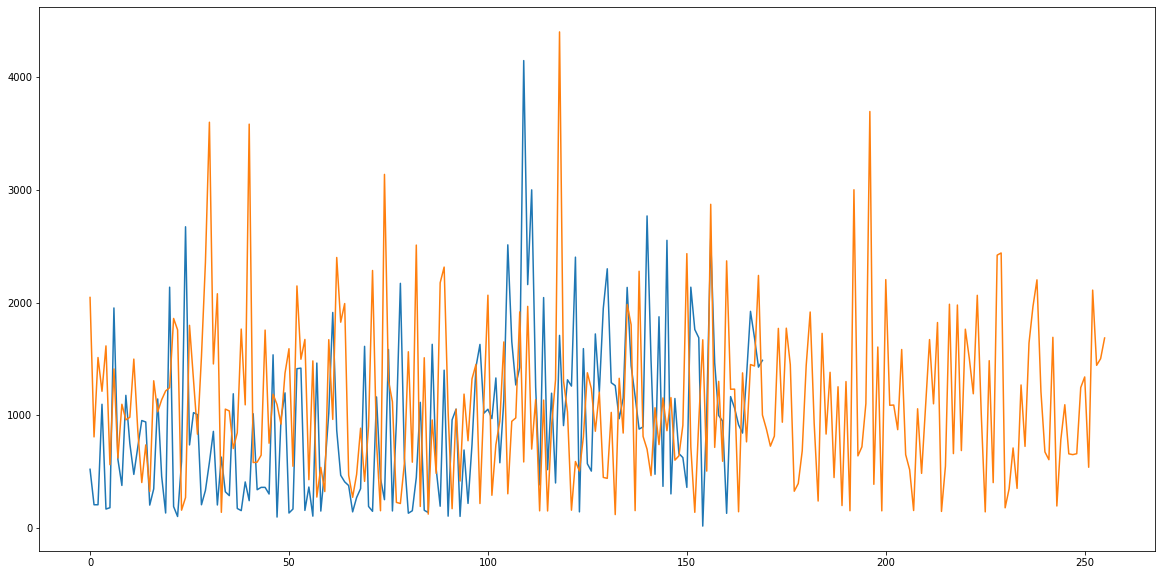

In [14]:
import numpy as np
import matplotlib.pyplot as plt

len_train_texts = np.array([len(x) for x in train_texts])
len_val_texts = np.array([len(x) for x in val_texts])

print(len_train_texts.max(), len_train_texts.min(), len_train_texts.mean())
print(len_val_texts.max(), len_val_texts.min(), len_val_texts.mean())

plt.figure(figsize=(20,10))
plt.plot(len_train_texts)
plt.plot(len_val_texts)

# Split documents in groups

In [15]:
import math

def split_list(input, max_length):
    result = []
    for i in range(math.ceil(len(input) / max_length)):
        result.append(input[i*max_length : (i*max_length) + max_length])
    
    return result

In [16]:
MAX_DOCUMENT_LENGTH = 150

train_texts = [group for doc in train_texts for group in split_list(doc, MAX_DOCUMENT_LENGTH)]
train_tags = [group for doc in train_tags for group in split_list(doc, MAX_DOCUMENT_LENGTH)]

val_texts = [group for doc in val_texts for group in split_list(doc, MAX_DOCUMENT_LENGTH)]
val_tags = [group for doc in val_tags for group in split_list(doc, MAX_DOCUMENT_LENGTH)]

In [17]:
len(train_texts), len(train_tags), len(val_texts), len(val_tags)

(1156, 1156, 2041, 2041)

In [18]:
len_train_texts = np.array([len(x) for x in train_texts])
len_val_texts = np.array([len(x) for x in val_texts])

print(len_train_texts.max(), len_train_texts.min(), len_train_texts.mean())
print(len_val_texts.max(), len_val_texts.min(), len_val_texts.mean())

150 1 139.23010380622839
150 1 140.609505144537


In [19]:
unique_tags = set(tag for doc in train_tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [20]:
unique_tags, tag2id, id2tag

({'B-problem',
  'B-test',
  'B-treatment',
  'I-problem',
  'I-test',
  'I-treatment',
  'O'},
 {'B-problem': 1,
  'B-test': 2,
  'B-treatment': 5,
  'I-problem': 0,
  'I-test': 3,
  'I-treatment': 6,
  'O': 4},
 {0: 'I-problem',
  1: 'B-problem',
  2: 'B-test',
  3: 'I-test',
  4: 'O',
  5: 'B-treatment',
  6: 'I-treatment'})

# Use pre-trained DistilBert Tokenizer

In [21]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained(PRE_TRAINED_BERT_MODEL)
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

In [22]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping'])

In [23]:
len(train_encodings['input_ids']), len(val_encodings['input_ids'])

(1156, 2041)

In [24]:
len(train_encodings['input_ids'][0])

444

# Format labels for sub token splitting

In [25]:
import numpy as np

def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)

        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

train_labels = encode_tags(train_tags, train_encodings)
val_labels = encode_tags(val_tags, val_encodings)

In [26]:
len(train_labels), len(val_labels)

(1156, 2041)

In [27]:
len(train_labels[0])

444

# Create Dataset loader

In [28]:
import torch

class WNUTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings.pop("offset_mapping") # we don't want to pass this to the model
val_encodings.pop("offset_mapping")
train_dataset = WNUTDataset(train_encodings, train_labels)
val_dataset = WNUTDataset(val_encodings, val_labels)

# Instantiate Model from PyTorch class module

In [29]:
from transformers import BertConfig
config = BertConfig.from_pretrained(PRE_TRAINED_BERT_MODEL, num_labels=len(unique_tags)) 

In [30]:
model = DistilBertForTokenClassification(config)

# Load Model Weights

In [31]:
weight = torch.load(PRE_TRAINED_BERT_MODEL + '_weight.pth', map_location='cpu')

In [32]:
model.load_state_dict(weight)

<All keys matched successfully>

# Fine Tune DistilBert using PyTorch

In [33]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(10):
    epoch_loss = 0.0
    num_batch = 0
    for i, batch in enumerate(train_loader, 0):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        #print(f"Epoch {epoch} Batch {i} : Loss {loss.data}")
        epoch_loss += loss.item()
        num_batch += 1
    print(f"Epoch {epoch} : Loss {epoch_loss / num_batch}")



Epoch 0 : Loss 0.5430440157651901
Epoch 1 : Loss 0.1927720400160306
Epoch 2 : Loss 0.12077745933034649
Epoch 3 : Loss 0.08059130838676674
Epoch 4 : Loss 0.05926209328415459
Epoch 5 : Loss 0.0397894146711859
Epoch 6 : Loss 0.028831282898477497
Epoch 7 : Loss 0.02322122789536641
Epoch 8 : Loss 0.018607878177235387
Epoch 9 : Loss 0.015631102395486342


# Validate Model

In [34]:
testloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [35]:
predictions = []
actual = []
with torch.no_grad():
   for i, batch in enumerate(testloader, 0):
     input_ids = batch['input_ids'].to(device)
     attention_mask = batch['attention_mask'].to(device)
     outputs = model(input_ids, attention_mask)
     predictions.append(outputs[0].cpu())
     actual.append(batch['labels'])
predictions = np.concatenate(predictions)
actual = np.concatenate(actual)

In [36]:
predicted_tokens = np.argmax(predictions, axis=2)

In [37]:
predicted_tags = []

for p_tokens, a_tokens in zip(predicted_tokens, actual):
  a_mask = a_tokens!=-100
  word_tokens = p_tokens[a_mask]
  iob_tags = [id2tag[x] for x in word_tokens]
  predicted_tags.append(iob_tags)

In [38]:
!pip install seqeval

     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=22bce1c28dfcc77ec588e03434ce8bc357154b76f342f5692055d9193597c8ab
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [39]:
from seqeval.metrics import f1_score

In [40]:
f1_score(val_tags, predicted_tags)

0.778728988314691